# Load the LGMR data

In [1]:
import xarray as xr
# open the 'LGMR_GMST_ens.nc' file
ds_sat = xr.open_dataset('data/LGMR_SAT_climo.nc')
ds_sat

c:\Users\zps19\.conda\envs\pz-env\lib\site-packages\xarray\coding\variables.py:148: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


<xarray.Dataset>
Dimensions:  (lat: 96, lon: 144, age: 120)
Coordinates:
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * age      (age) float32 100.0 300.0 500.0 ... 2.35e+04 2.37e+04 2.39e+04
Data variables:
    sat      (age, lat, lon) float32 ...
    sat_std  (age, lat, lon) float32 ...

# Remove the data with age<11

In [2]:

ds_sat = ds_sat.where(ds_sat.age>=11000, drop=True)

c:\Users\zps19\.conda\envs\pz-env\lib\site-packages\xarray\coding\variables.py:148: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


In [62]:
ds_sat

<xarray.Dataset>
Dimensions:  (age: 65, lat: 96, lon: 144)
Coordinates:
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * age      (age) float32 1.11e+04 1.13e+04 1.15e+04 ... 2.37e+04 2.39e+04
Data variables:
    sat      (age, lat, lon) float32 -50.42 -50.41 -50.41 ... -41.98 -41.98
    sat_std  (age, lat, lon) float32 0.7924 0.7944 0.7947 ... 3.529 3.533 3.536

# Create the centered data

In [3]:
import numpy as np
import xarray as xr

mean_data = ds_sat['sat'].mean(dim='age')

# Subtract the mean from the data
centered_data = ds_sat['sat'] - mean_data

ds_sat['sat_centered'] = centered_data
ds_sat

<xarray.Dataset>
Dimensions:       (age: 65, lat: 96, lon: 144)
Coordinates:
  * lat           (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon           (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * age           (age) float32 1.11e+04 1.13e+04 1.15e+04 ... 2.37e+04 2.39e+04
Data variables:
    sat           (age, lat, lon) float32 -50.42 -50.41 -50.41 ... -41.98 -41.98
    sat_std       (age, lat, lon) float32 0.7924 0.7944 0.7947 ... 3.533 3.536
    sat_centered  (age, lat, lon) float32 4.068 4.07 4.085 ... -0.7781 -0.7796

# Create the centered and weighted data

In [4]:
import numpy as np

weight = np.cos(np.deg2rad(ds_sat['lat']))
print('shape of the weight:', weight.shape)

# set weight to 0 if it is smaller than 0
weight = xr.where(weight < 0, 0, weight)

ds_sat['weight']=weight
# Multiply 'sat_anomalies' with the weight
sat_anomalies_weighted = ds_sat['sat_centered'] * weight

# Add 'sat_anomalies_weighted' as a new data variable in the dataset
ds_sat['sat_centered_weighted'] = sat_anomalies_weighted

sat_centered_weighted = ds_sat['sat_centered_weighted'].values
sat_centered_weighted = sat_centered_weighted.reshape(len(ds_sat['age']), 96*144)
print('shape of the reshaped sat_centered_weighted:', sat_centered_weighted.shape)

shape of the weight: (96,)
shape of the reshaped sat_centered_weighted: (65, 13824)


In [19]:
ds_sat

<xarray.Dataset>
Dimensions:                (age: 65, lat: 96, lon: 144)
Coordinates:
  * lat                    (lat) float32 -90.0 -88.11 -86.21 ... 88.11 90.0
  * lon                    (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * age                    (age) float32 1.11e+04 1.13e+04 ... 2.37e+04 2.39e+04
Data variables:
    sat                    (age, lat, lon) float32 -50.42 -50.41 ... -41.98
    sat_std                (age, lat, lon) float32 0.7924 0.7944 ... 3.533 3.536
    sat_centered           (age, lat, lon) float32 4.068 4.07 ... -0.7796
    weight                 (lat) float32 0.0 0.03306 0.06609 ... 0.03306 0.0
    sat_centered_weighted  (age, lat, lon) float32 0.0 0.0 0.0 ... -0.0 -0.0

# Compare the original, centered, and centered_weighted data

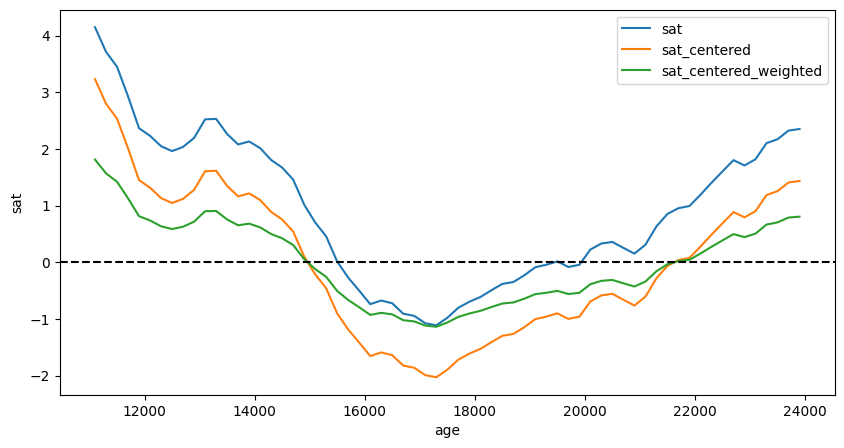

In [5]:
# plot the sat, sat_centered, and sat_centered_weighted in the same plot for lat=0 and lon=0
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(ds_sat['age'], ds_sat['sat'][:, 77, 90], label='sat')
ax.plot(ds_sat['age'], ds_sat['sat_centered'][:, 77, 90], label='sat_centered')
ax.plot(ds_sat['age'], ds_sat['sat_centered_weighted'][:, 77, 90], label='sat_centered_weighted')
# plot a line at y=0
ax.axhline(y=0, color='black', linestyle='--')

ax.set_xlabel('age')
ax.set_ylabel('sat')
ax.legend()

plt.show()

# Calculating Eigenvectors using SVD

In [21]:
import numpy as np

sat_centered_weighted_test=ds_sat['sat_centered_weighted'].values.reshape(len(ds_sat['age']), 96*144)
sat_centered_weighted_test=sat_centered_weighted_test.T
print('shape of the reshaped sat_centered_weighted_test:', sat_centered_weighted_test.shape)

u, s, vh = np.linalg.svd(sat_centered_weighted_test, full_matrices=True)
print('shape of u, s, vh:', u.shape, s.shape, vh.shape)


shape of the reshaped sat_centered_weighted_test: (13824, 65)
shape of u, s, vh: (13824, 13824) (65,) (65, 65)


# Get EOFs and PCs

In [22]:
EOFs=u[:,0:2]
EOF1=EOFs[:, 0]
EOF2=EOFs[:, 1]

# calculate the variance explained by the first 10 PCs
variance_explained = s**2 / np.sum(s**2)

print('shape of EOFs:', EOFs.shape)
PCs=sat_centered_weighted_test.T.dot(EOFs)
print('shape of PCs:', PCs.shape)

shape of EOFs: (13824, 2)
shape of PCs: (65, 2)


In [23]:
variance_explained

array([8.98258686e-01, 8.04840028e-02, 7.40235392e-03, 5.19952085e-03,
       2.63320236e-03, 2.17852276e-03, 1.61866844e-03, 7.41521362e-04,
       3.43156047e-04, 2.67069583e-04, 2.14783169e-04, 1.25641935e-04,
       1.05506122e-04, 8.99674415e-05, 6.97138094e-05, 5.73843863e-05,
       4.11159162e-05, 2.85841179e-05, 2.40365462e-05, 2.04937060e-05,
       1.56445531e-05, 1.33408384e-05, 1.00197658e-05, 9.03837099e-06,
       8.46516286e-06, 6.73880777e-06, 5.06810420e-06, 4.94178948e-06,
       3.91775711e-06, 3.26156487e-06, 2.69328530e-06, 2.56359567e-06,
       1.72111925e-06, 1.29166426e-06, 1.08624761e-06, 7.33775494e-07,
       6.68961661e-07, 6.38538950e-07, 5.43628573e-07, 4.89633464e-07,
       4.49905457e-07, 3.24484660e-07, 2.99716788e-07, 2.64120160e-07,
       2.16782738e-07, 1.99238471e-07, 1.74655526e-07, 1.58337343e-07,
       1.42285387e-07, 1.23404902e-07, 1.21093862e-07, 9.92318832e-08,
       9.25580537e-08, 7.17794606e-08, 6.59268409e-08, 5.13216385e-08,
      

# Save EOFs to local files

In [24]:
# Reshape EOF1 and EOF2 to 2D
EOF1 = EOF1.reshape(ds_sat.lat.size, ds_sat.lon.size)
EOF2 = EOF2.reshape(ds_sat.lat.size, ds_sat.lon.size)

# Store EOF1 and EOF2 into the ds_sat
ds_sat['EOF1'] = (('lat', 'lon'), EOF1)
ds_sat['EOF2'] = (('lat', 'lon'), EOF2)

# store the ds_sat into a netcdf file
data_dir = 'D:/VScode/Last_deglaciation/data'
ds_sat.to_netcdf(data_dir + '/ds_sat_EOFs.nc')

PermissionError: [Errno 13] Permission denied: 'D:\\VScode\\Last_deglaciation\\data\\ds_sat_EOFs.nc'

## plot PCs, which is the corrdinate of the data on the eigenvetors

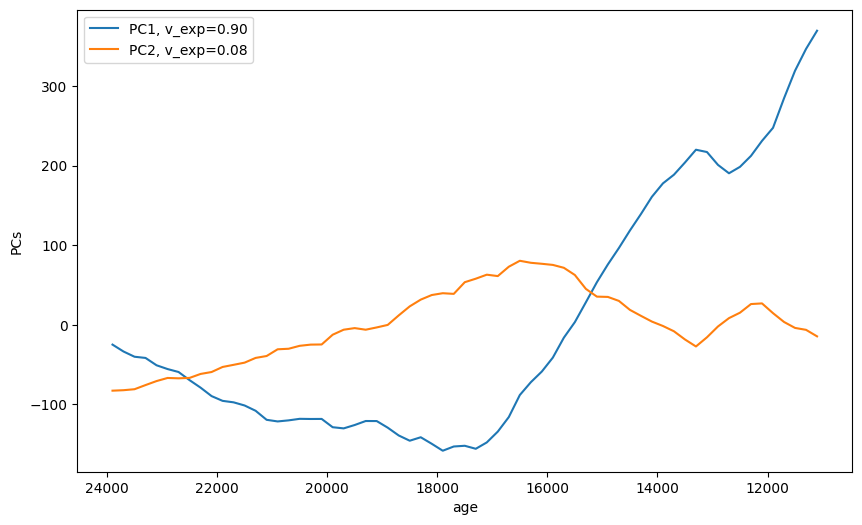

In [11]:

# plot the PCs against the age
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(ds_sat['age'], -1*PCs[:, 0], label='PC1, v_exp={:.2f}'.format(variance_explained[0]))
ax.plot(ds_sat['age'], PCs[:, 1], label='PC2, v_exp={:.2f}'.format(variance_explained[1]))

# reverse the x-axis
ax.invert_xaxis()

ax.set_xlabel('age')
ax.set_ylabel('PCs')
ax.legend()

## plot the hist of EOFs

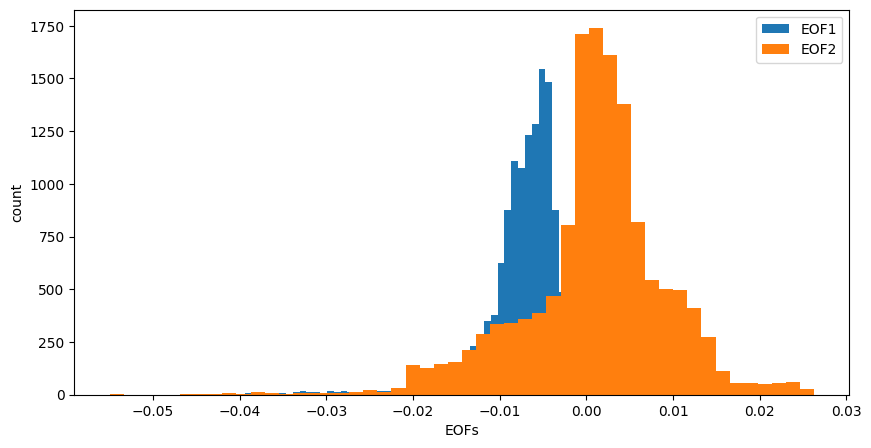

In [12]:
# plot histogram of EOFs
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(EOFs[:, 0], label='EOF1', bins=50)
ax.hist(EOFs[:, 1], label='EOF2', bins=50)

ax.set_xlabel('EOFs')
ax.set_ylabel('count')
ax.legend()

# Plot heatmap for EOFs

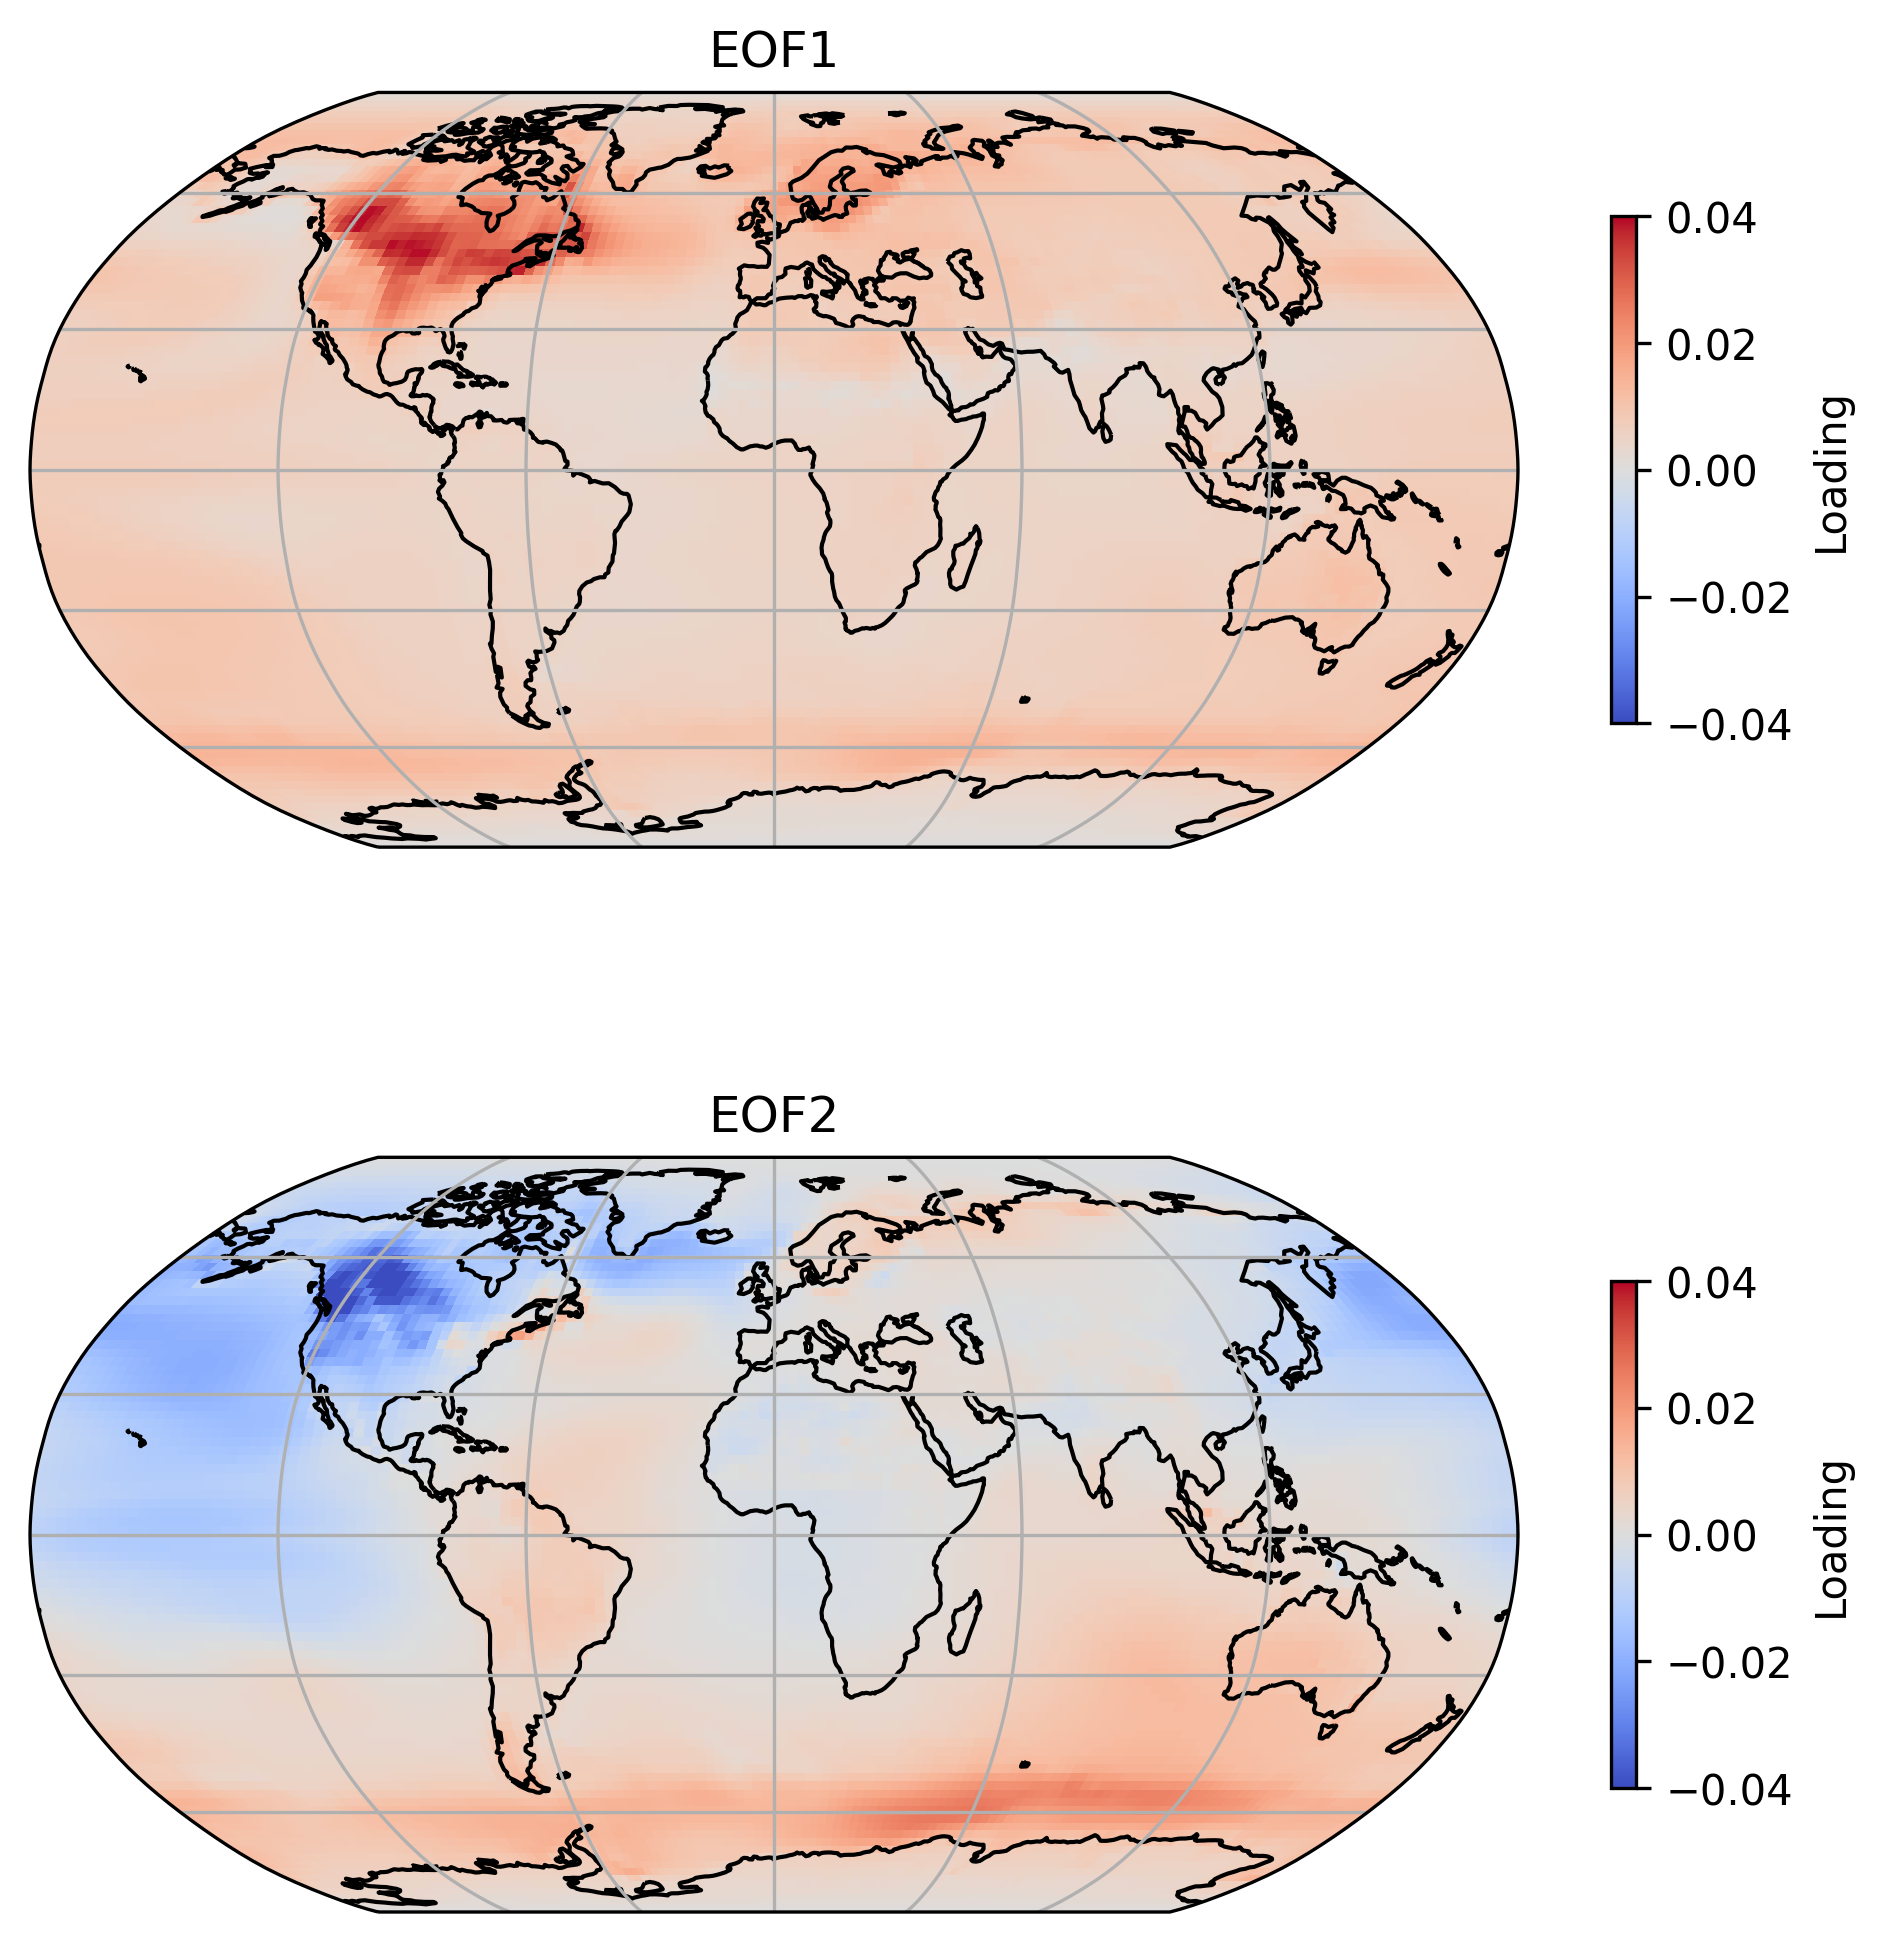

In [13]:
# reshape EOF1 and EOF2 to 3D array
EOF1 = EOFs[:, 0].reshape(96, 144)
EOF2 = EOFs[:, 1].reshape(96, 144)

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# create a figure and axis
fig, axs = plt.subplots(2,1,figsize=(8, 9), subplot_kw=dict(projection=ccrs.Robinson()),dpi=300)

ax = axs[0]
# add coastline and gridlines
ax.add_feature(cfeature.COASTLINE)
ax.gridlines(draw_labels=False)

sat =EOF1*-1
# plot heatmap
cmap = plt.cm.get_cmap('coolwarm')
im = ax.pcolormesh(ds_sat.lon, ds_sat.lat, sat, transform=ccrs.PlateCarree(), cmap=cmap, vmin=-0.04, vmax=0.04, shading='auto')
ax.set_title('EOF1')

# add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.05, shrink=0.5)
cbar.ax.set_ylabel('Loading')

ax = axs[1]
# add coastline and gridlines
ax.add_feature(cfeature.COASTLINE)
ax.gridlines(draw_labels=False)

sat =EOF2
# plot heatmap
cmap = plt.cm.get_cmap('coolwarm')
im = ax.pcolormesh(ds_sat.lon, ds_sat.lat, sat, transform=ccrs.PlateCarree(), cmap=cmap, vmin=-0.04, vmax=0.04, shading='auto')
ax.set_title('EOF2')

# add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.05, shrink=0.5)
cbar.ax.set_ylabel('Loading')

# adjust the space between subplots
fig.subplots_adjust(hspace=0.05)

plt.show()


# Plot EOFs in two dimension

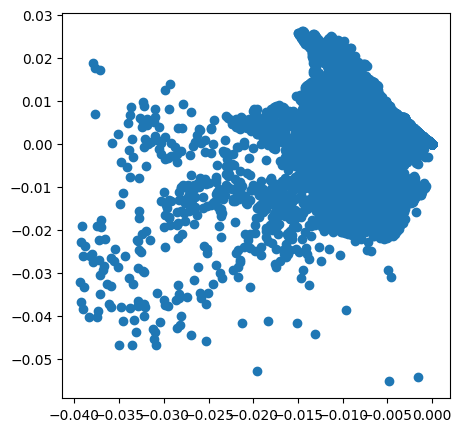

In [14]:
# plot the temp_score using 2d scatter plot

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(EOFs[:,0], EOFs[:,1])
plt.show()

# GMM on EOFs

In [33]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import zscore
import numpy as np
from sklearn.mixture import GaussianMixture
import xarray as xr
import matplotlib.pyplot as plt


def GMM(data, ds_sat,n_components=5):
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    # n_components=5
    sat_shape=ds_sat['sat'].shape

    # create a 2D GMM model
    gmm_model = GaussianMixture(n_components=n_components, covariance_type='full')

    # fit the model to the two columns of PCA scores
    gmm_model.fit(data)

    # get the predicted class labels for each data point
    class_labels = gmm_model.predict(data)

    # new_ds=ds_sat.copy()
    # add the class labels to the xarray dataset
    ds=ds_sat.copy()
    ds['class_label'] = (('lat', 'lon'), class_labels.reshape(sat_shape[1], sat_shape[2]))

    # plot the results
    fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=300)

    # plot the scatter plot of the two columns
    for i in range(n_components):
        mask = class_labels == i
        # ax[0].scatter(sat_scores[:, 0][mask], sat_scores[:, 1][mask], s=10, alpha=0.5, color=colors[i % len(colors)])
        ax[0].scatter(data[:, 0][mask], data[:, 1][mask], s=10, alpha=0.5, color=colors[i])

    # plot the contour plot of the fitted GMM
    x, y = np.meshgrid(np.linspace(np.min(data[:, 0]), np.max(data[:, 0]), 100),
                        np.linspace(np.min(data[:, 1]), np.max(data[:, 1]), 100))
    XX = np.array([x.ravel(), y.ravel()]).T
    Z = -gmm_model.score_samples(XX)
    Z = Z.reshape(x.shape)
    ax[1].contour(x, y, Z, cmap='coolwarm_r')

    # Add labels and title
    ax[0].set_xlabel('EOF 1')
    ax[0].set_ylabel('EOF 2')
    ax[1].set_xlabel('EOF 1')
    ax[1].set_ylabel('EOF 2')
    ax[0].set_title('Scatter plot of loadings')
    ax[1].set_title('Contour plot of fitted GMM')

    plt.tight_layout()
    plt.show()

    return ds

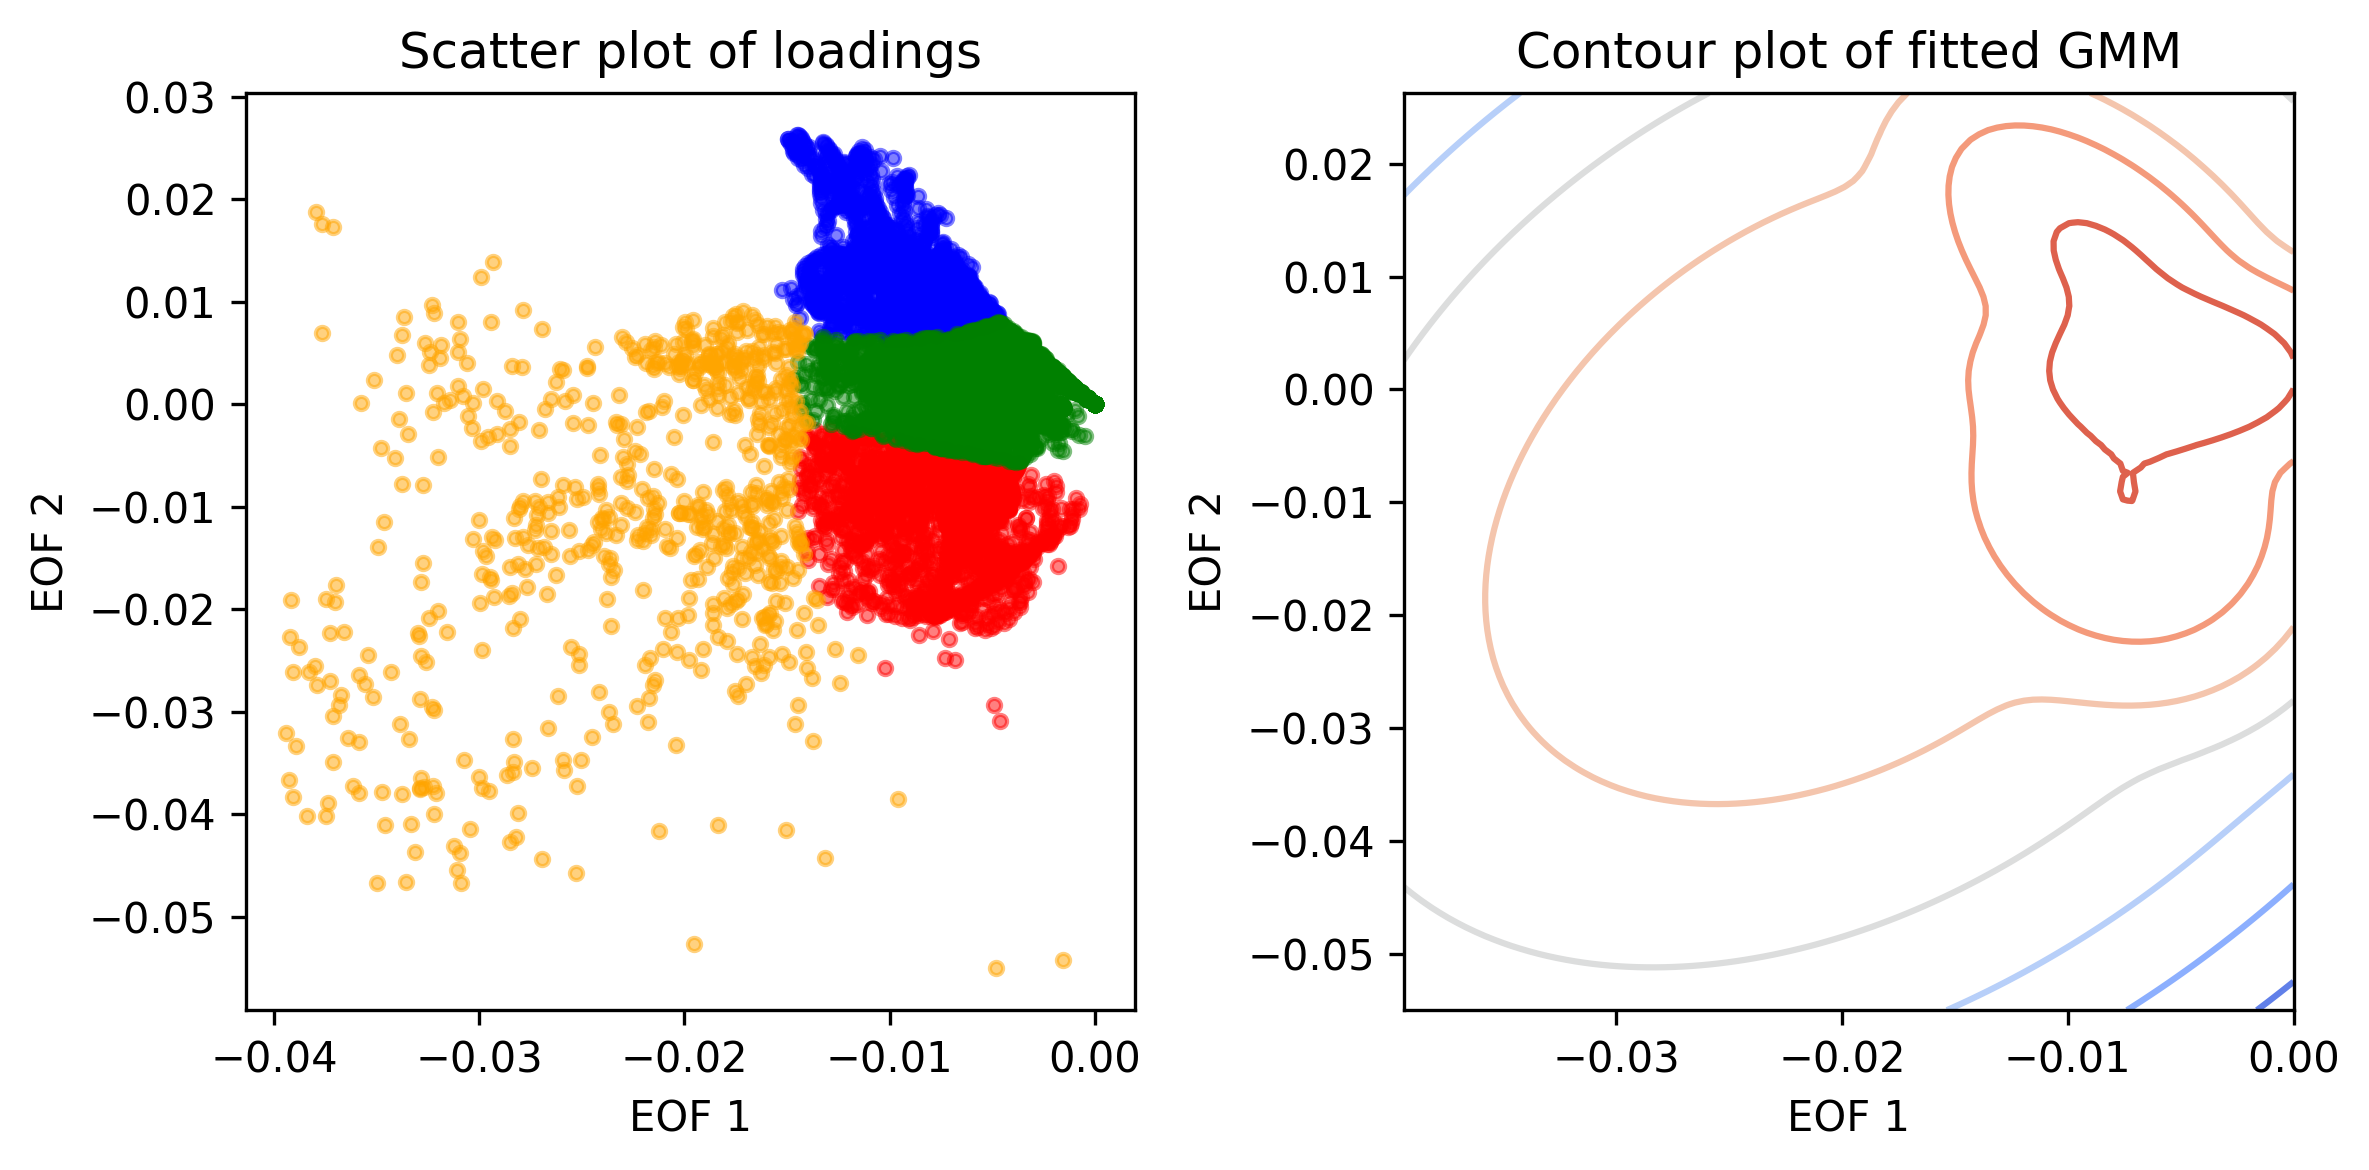

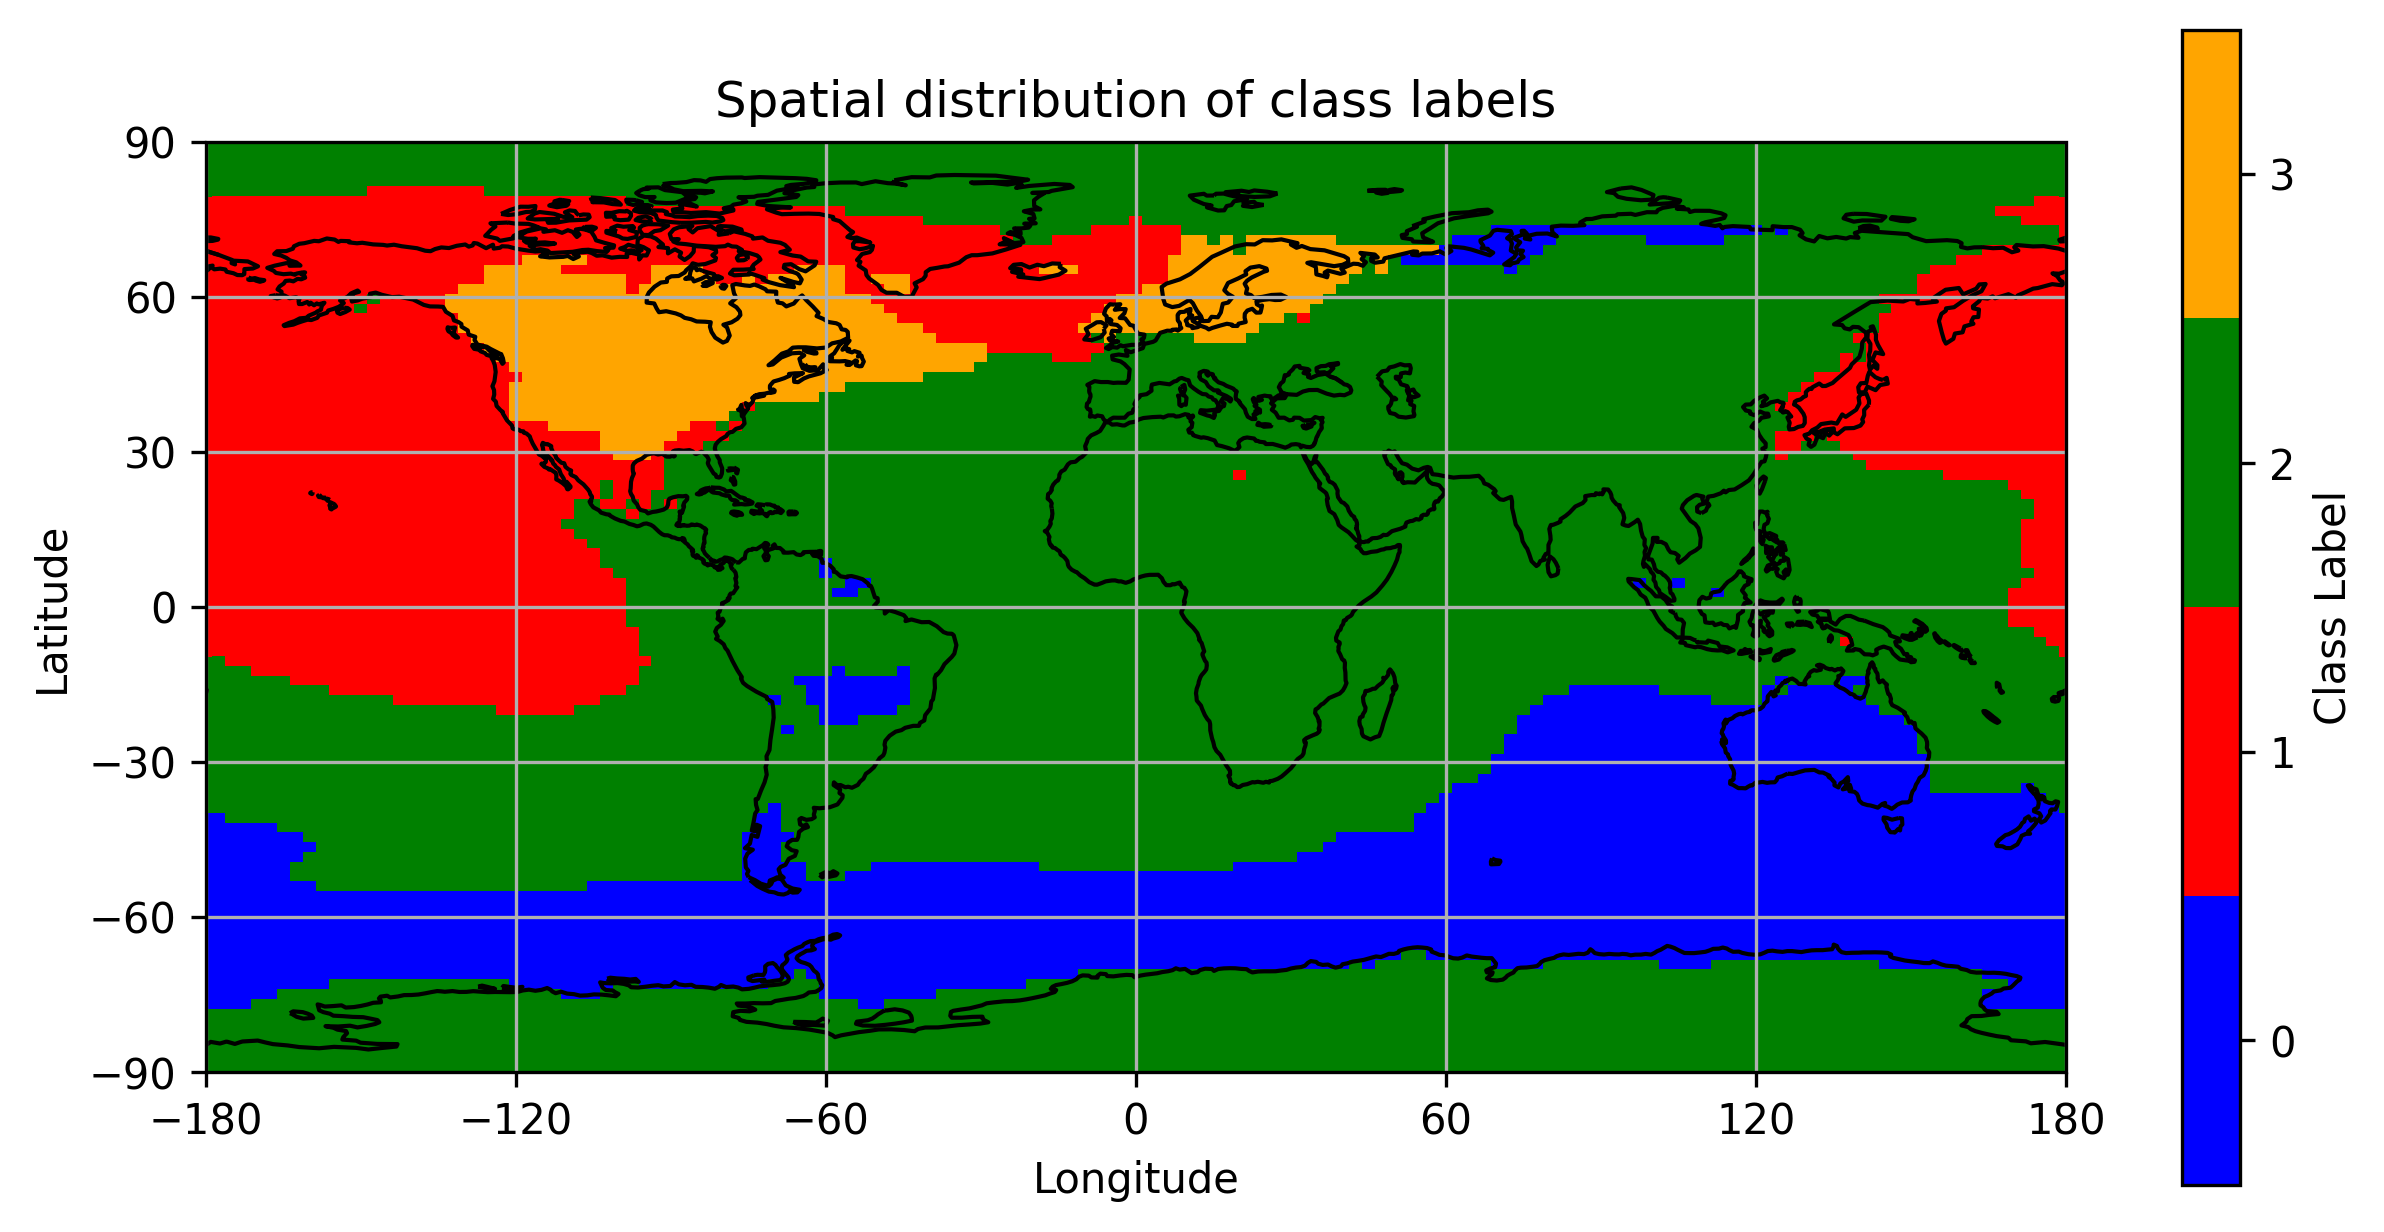

In [35]:
ds_EOFs_GMM=GMM(EOFs, ds_sat,n_components=4)

from toolbox import GMM_functions as gf
gf.plot_labels(ds_EOFs_GMM)

# Calculate the average curve of each class and sort the average curves according to deglacial transition age

In [13]:
import numpy as np
import xarray as xr


# label2plot=[]
def find_labels_transition(ds,variable='sat'):

    min_age_list=[]
    labels=[]
    classlabel_age=[]
    sequence_class_age=[]

    ds['transition_age_of_label'] = xr.full_like(ds['sat'].isel(age=0), np.nan)
    for label in np.unique(ds['class_label']):
        # label2plot = label
        label_mask = ds['class_label'] == label
        label_sat = ds[variable].where(label_mask)

        weight=ds['weight'].where(label_mask)
        label_sat=label_sat*weight

        label_sat_average = label_sat.sum(dim=('lat', 'lon'))/weight.sum(dim=('lat', 'lon'))
        
        min_age = ds['age'].isel(age=label_sat_average.argmin(dim='age'))
        # min_sat = label_sat_average.min(dim='age')
        min_age_list.append(min_age.values)
        labels.append(label)
        classlabel_age.append([label,min_age.values])
        
        age_min_sat = xr.where(label_mask, min_age, np.nan)
        ds['transition_age_of_label'] = ds['transition_age_of_label'].where(~label_mask, age_min_sat)

    # compute sequence
    classlabel_age.sort(key=lambda x: x[1], reverse=True)
    ds['sequence'] = xr.full_like(ds['sat'].isel(age=0), np.nan)
    #min_age_list = np.unique(ds['transition_age_of_label'].values[~np.isnan(ds['transition_age_of_label'].values)])
    # min_age_list.sort()
    # print(min_age_list)
    for i in range(len(classlabel_age)):#enumerate(np.unique(ds['class_label'])):
        label_mask = ds['class_label'] == classlabel_age[i][0]
        sequence_class_age.append([i,classlabel_age[i][0],classlabel_age[i][1]])
        ds['sequence'] = xr.where(label_mask, i, ds['sequence'])
    ds['sequence'] = ds['sequence'].fillna(-2147483648).astype(int)

    return ds,sequence_class_age

##############################################################################################
# function to plot the class labels on a map

import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np


def plot_all_label_at_sequence(ds,variable='sat',plot_class=False):
    ds,sequence_class_age=find_labels_transition(ds,variable=variable)
    sequence_label = ds['sequence']
    sat_label = ds['class_label']
    # create a figure and axis
    nrow=len(np.unique(sat_label))
    fig = plt.figure(figsize=(16, 5*nrow),dpi=300)

    for i in np.unique(ds['sequence']):
        label2plot=sequence_class_age[i][1]
        # add coastline and gridlines
        ax = fig.add_subplot(nrow, 2, 2*i+1, projection=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE)
        ax.gridlines()

        # plot heatmap
        # colors = list(mcolors.TABLEAU_COLORS.values())
        # colors = colors[1:len(np.unique(sat_label))+1]
        colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
        cmap = mcolors.ListedColormap(['#ffffff', colors[label2plot]])
        im = ax.pcolormesh(ds.lon, ds.lat, sat_label==label2plot, transform=ccrs.PlateCarree(), cmap=cmap, shading='auto')   
        ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
        ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
        # add lon and lat labels
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title(f'Sequence Label: {str(sequence_class_age[i][0])}, Class label: {str(sequence_class_age[i][1])}, Age of transition: {str(int(sequence_class_age[i][2]))}')


    ##########################################
    # calculate average sat data for each label

        # label_mask = ds['class_label'] == label2plot
        # label_sat = ds[variable].where(label_mask)
        # label_sat_average = label_sat.mean(dim=('lat', 'lon'))

        label_mask = ds['class_label'] == label2plot
        label_sat = ds[variable].where(label_mask)

        weight=ds['weight'].where(label_mask)
        label_sat=label_sat*weight

        label_sat_average = label_sat.sum(dim=('lat', 'lon'))/weight.sum(dim=('lat', 'lon'))
        

        min_age = ds['age'].isel(age=label_sat_average.argmin(dim='age'))
        min_sat = label_sat_average.min(dim='age')

        # create axis for the second plot
        ax1 = fig.add_subplot(nrow, 2, 2*i+2)

        # timing for climate transitions, data from Rasmussen et al., 2014, in b2k
        HS1=np.array([17480,14692])-50 # convert to b1950
        BA=np.array([14692,12896])-50
        YD=np.array([12896,11703])-50

        # plot the timing of climate transitions using vertical lines
        ax1.axvline(x=HS1[0],color='black',linestyle='--') # HS1
        ax1.axvline(x=HS1[1],color='black',linestyle='--') # HS1

        ax1.axvline(x=BA[0],color='black',linestyle='--') # BA
        ax1.axvline(x=BA[1],color='black',linestyle='--') # BA

        ax1.axvline(x=YD[0],color='black',linestyle='--') # YD
        ax1.axvline(x=YD[1],color='black',linestyle='--') # YD

        if plot_class:
            # plot all sat data in the same label as light grey lines
            # reshape the label_sat to a 2D array
            label_sat = label_sat.values
            label_sat = label_sat.reshape(label_sat.shape[0], label_sat.shape[1]*label_sat.shape[2])
            print(label_sat.shape)
            for i in range(label_sat.shape[1]):
                ax1.plot(ds['age'],label_sat[:,i], color='lightgray', alpha=0.1)

        ax1.plot(ds.age,label_sat_average,color=colors[label2plot])
        ax1.plot(min_age,min_sat,'ko')
        # print(np.max(ax1.get_ylim()))
        
        # add labels for the vertical lines
        ax1.text(HS1[0]-0.7*(HS1[0]-HS1[1]),np.max(ax1.get_ylim())-0.1*(np.max(ax1.get_ylim())-np.min(ax1.get_ylim())),'HS1',rotation=90)
        ax1.text(BA[0]-0.7*(BA[0]-BA[1]),np.max(ax1.get_ylim())-0.1*(np.max(ax1.get_ylim())-np.min(ax1.get_ylim())),'BA',rotation=90)
        ax1.text(YD[0]-0.7*(YD[0]-YD[1]),np.max(ax1.get_ylim())-0.1*(np.max(ax1.get_ylim())-np.min(ax1.get_ylim())),'YD',rotation=90)

        ax1.set_xlabel('Age')
        ax1.set_ylabel(f'{variable}')
        #ax1.set_title('Class Label: '+str(label2plot))

    plt.show()

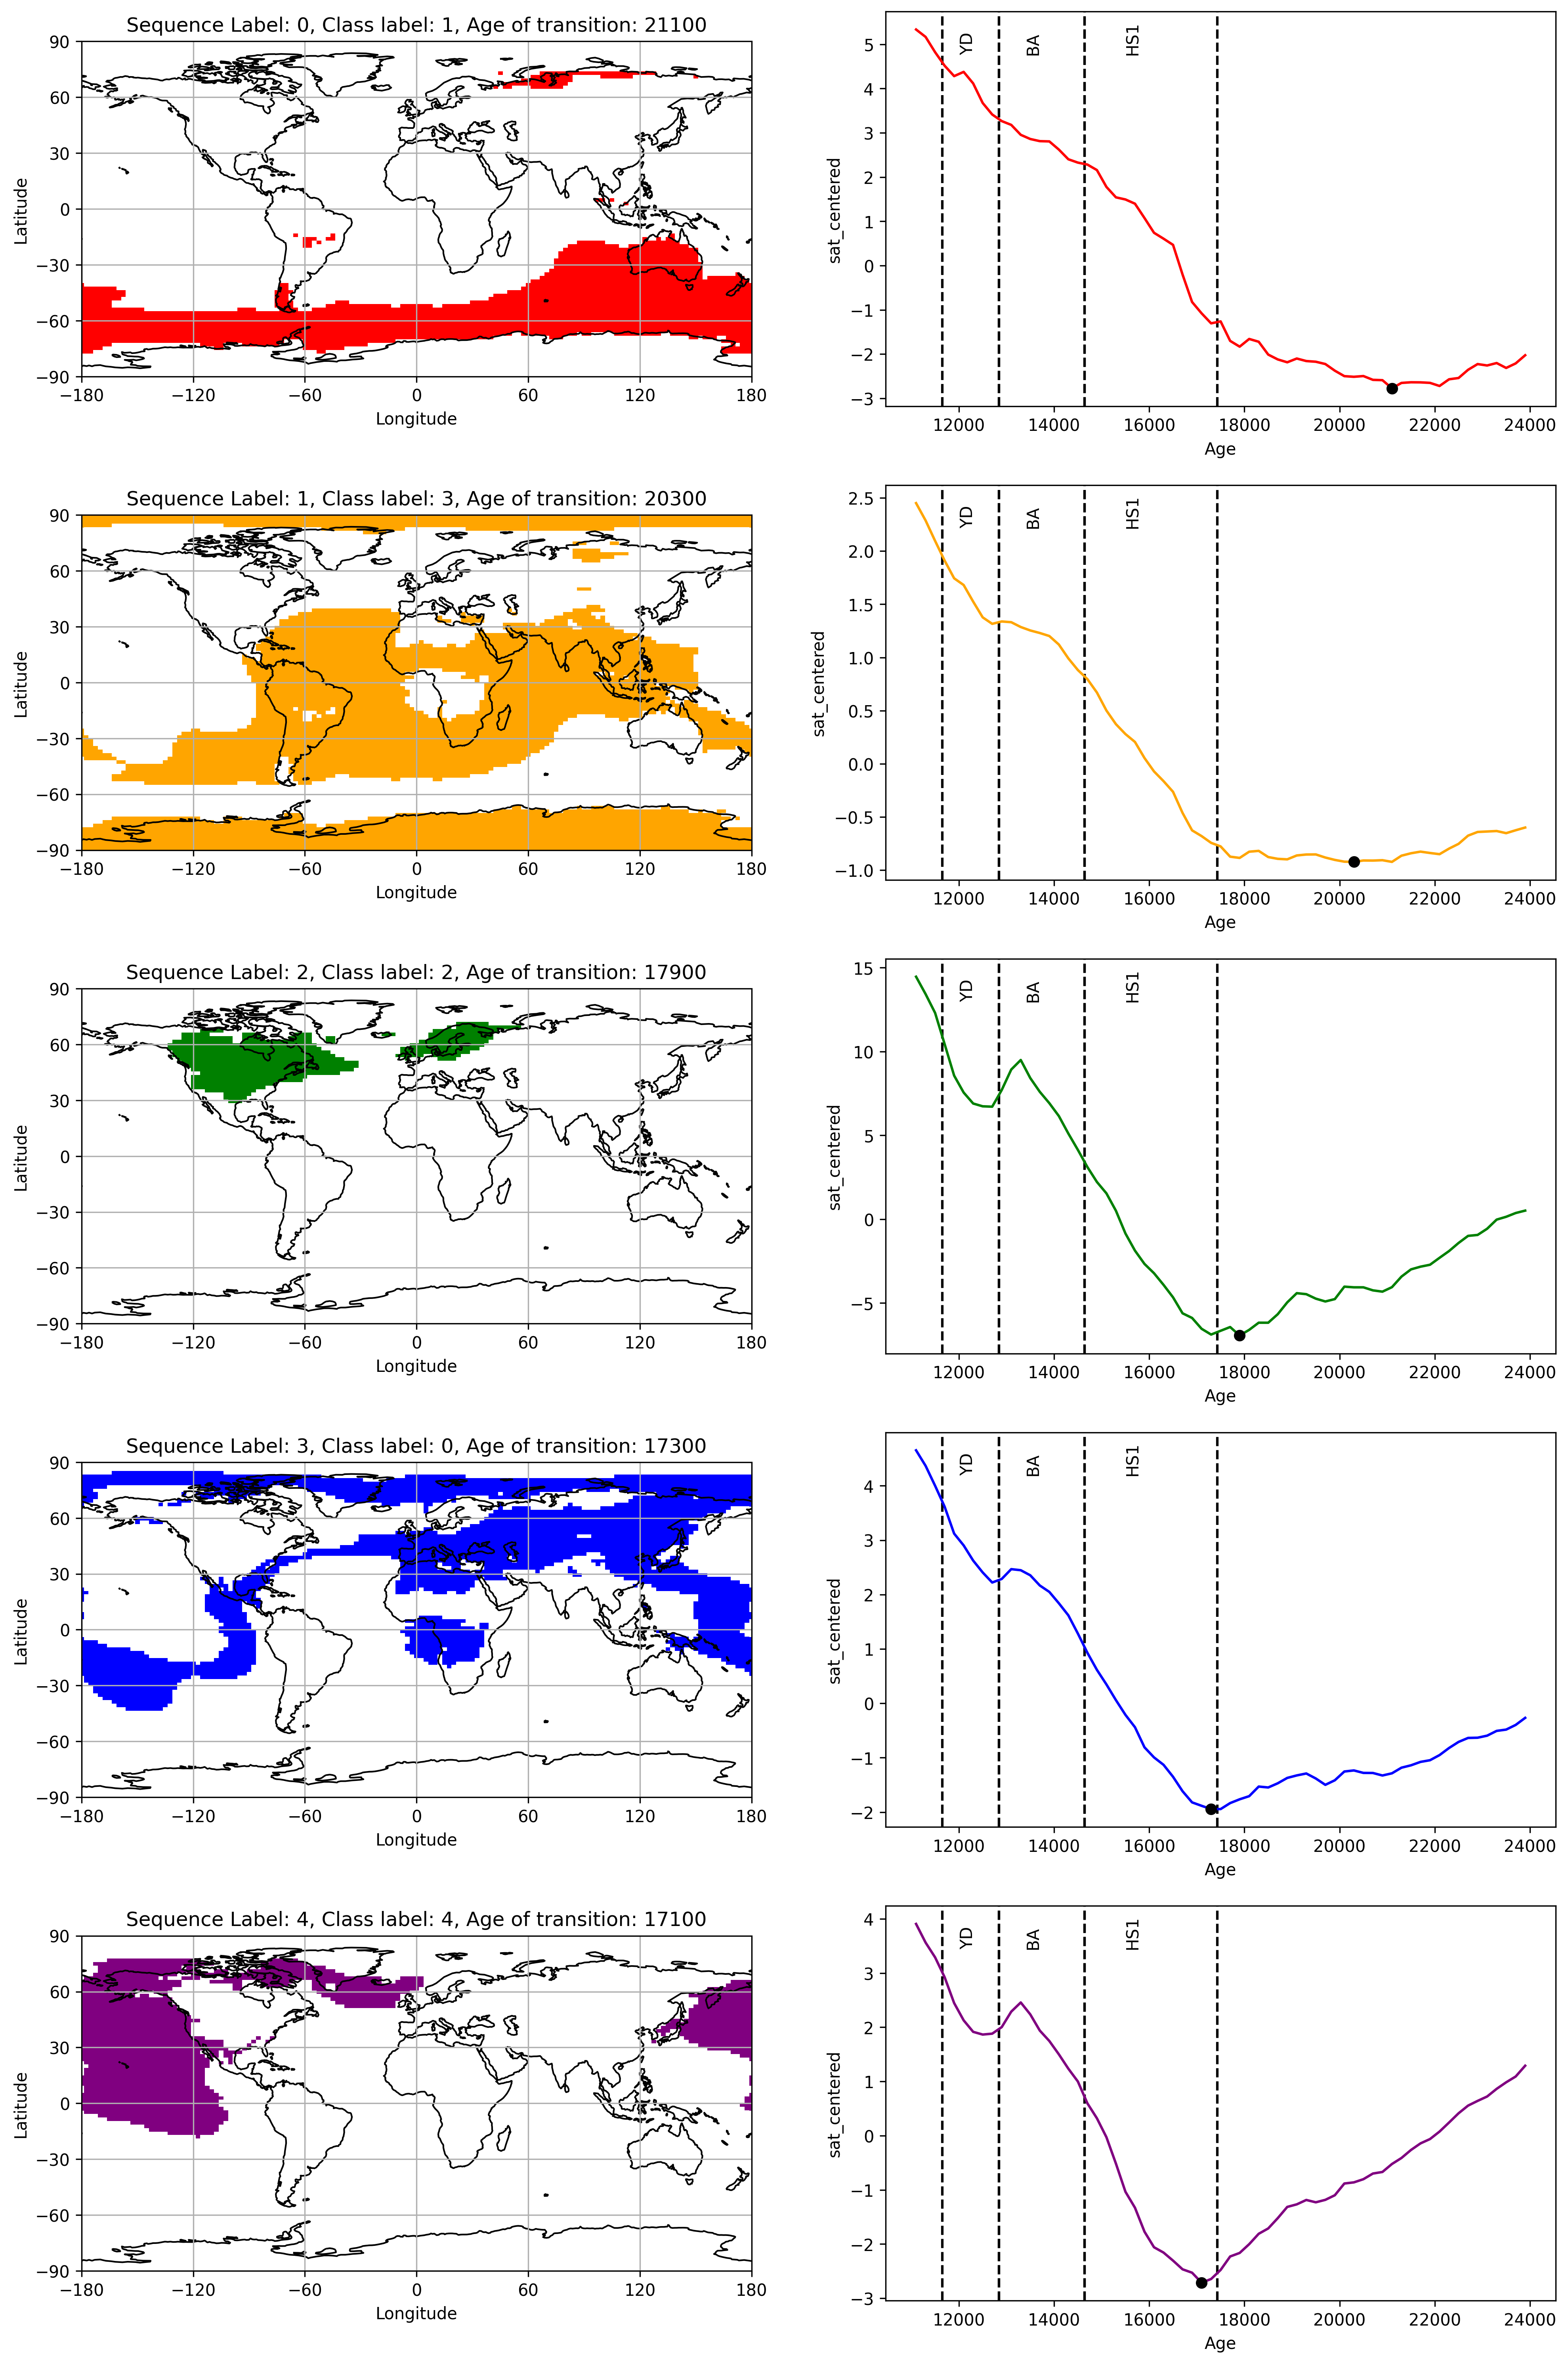

In [14]:
plot_all_label_at_sequence(ds_EOFs_GMM,variable='sat_centered')